# Twitter real disaster prediction: using natural language processing to predict real (or not) disaster-related tweets 

With the increase of the use of social networks as means of communication, organizations are monitoring Twitter for emergency cases assessment. Tweets from locals, when accurate, can give real-time information and therefore provide valuable insights into disaster events. In order to identify real from fake disaster-related tweets the data science loop was considered. For that, an exploratory data analysis and preprocessing was performed to better understand the scope of the tweets we had available for the training phase. With that, several neural network models were tested to access the best configuration for the problem at hand. Glove with LSMT showed the least overfitting scenario, with it a hyperparameter search space was configured so that Hyperband tuner determined the best hyperparameters and topology of the neural network. With the optimal parameters, a new network was configured which performed with f1 score performance above 80% over unseen data. 

## Import the Libraries

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn import model_selection

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
import keras.backend as K

import keras_tuner as kt

## Upload the data

In [33]:
# load the datsets
data = pd.read_csv('train.csv')

## EDA

C:\Users\gorre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


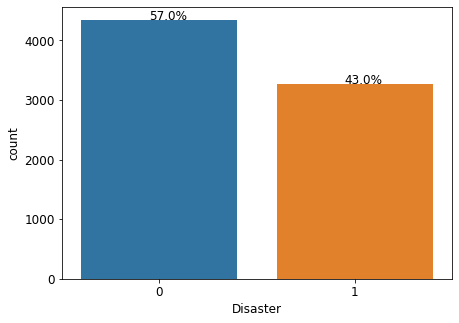

In [47]:
def add_percentages(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

plt.figure(figsize = (7,5))
ax = sns.countplot('target', data = data)
plt.xticks(size = 12)
plt.xlabel('Disaster?', size = 12)
plt.yticks(size = 12)
plt.ylabel('count', size = 12)

add_percentages(ax, data.target)

C:\Users\gorre\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average text length')

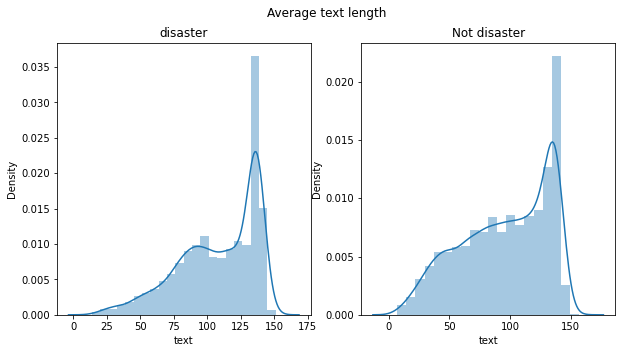

In [104]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

word = data[data['target']==1]['text'].apply(len)

sns.distplot(word,ax=ax1)
ax1.set_title('disaster')

word = data[data['target']==0]['text'].apply(len)

sns.distplot(word,ax=ax2)
ax2.set_title('Not disaster')
fig.suptitle('Average text length')

In [106]:
np.mean(data['text'].apply(len))

101.03743596479706

C:\Users\gorre\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gorre\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each data')

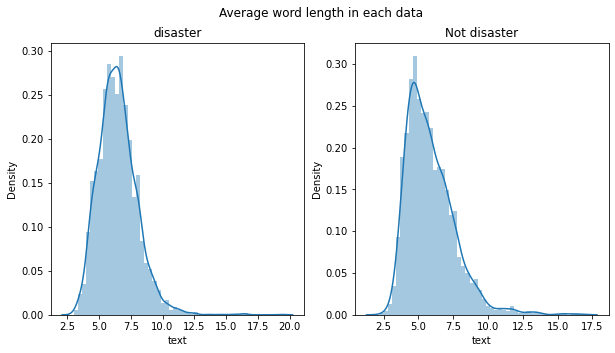

In [70]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

word=data[data['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1)
ax1.set_title('disaster')

word=data[data['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2)
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each data')

## Joining the data and Preprocessing

In [8]:
# show the number of missing values in the dataset
data.isnull().sum()

text      0
target    0
dtype: int64

In [9]:
# train/test split the text data and labels
features = data['text']
labels = data['target']

# the model will remember only the top 10000 most common words
max_words = 10000
max_len = 15
batch_size = 32

# split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=18)

In [10]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        i = re.sub('@', '', i)
        normalized.append(i)
    return normalized

#remove from the tweets undesired characters
X_train = normalize(X_train)
X_test = normalize(X_test)

In [11]:
#define the one hot encoder
def vectorize_sequences(sequences, dimension = max_words):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

In [12]:
# For train dataset define the tokenizer
token = Tokenizer(num_words = max_words, lower = True, split=' ', oov_token = True)
# fit the tokenizer to the train dataset
token.fit_on_texts(X_train)
# retreive the tokenizer word_index
word_index = token.word_index

# transfor the train and test data set to a sequence of integers
sequences = token.texts_to_sequences(X_train)
test_sequences = token.texts_to_sequences(X_test)

# pad the sequence of integer to the maximum length of the tweets
train_sequences_padded = pad_sequences(sequences, maxlen=max_len)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)

#vectorize the training and the test datasets
x_train = vectorize_sequences(train_sequences_padded)
x_test = vectorize_sequences(test_sequences_padded)

In [13]:
#vectorize the labels
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [14]:
# define the f1 score function to be used be Kerar to monitor the training phase of the networks
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [15]:
# defined the early stop strategy to be used in the training phase
stop_early = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=10)

## Model 1 - MLP

In [12]:
model = Sequential()
model.add(Dense(16, activation = 'relu', input_dim = max_words))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [f1_score])

In [13]:
# fit the model to the vectorized datasets
history = model.fit(x_train, y_train, epochs = 20,
                    batch_size = batch_size, validation_split = 0.2)

Epoch 1/20
153/153 [==============================] - 1s 3ms/step - loss: 0.6122 - f1_score: 0.4095 - val_loss: 0.5550 - val_f1_score: 0.6042
Epoch 2/20
153/153 [==============================] - 0s 3ms/step - loss: 0.4537 - f1_score: 0.7762 - val_loss: 0.4874 - val_f1_score: 0.7056
Epoch 3/20
153/153 [==============================] - 0s 2ms/step - loss: 0.3410 - f1_score: 0.8355 - val_loss: 0.4875 - val_f1_score: 0.7475
Epoch 4/20
153/153 [==============================] - 0s 2ms/step - loss: 0.2842 - f1_score: 0.8677 - val_loss: 0.5032 - val_f1_score: 0.7404
Epoch 5/20
153/153 [==============================] - 0s 2ms/step - loss: 0.2480 - f1_score: 0.8834 - val_loss: 0.5350 - val_f1_score: 0.7372
Epoch 6/20
153/153 [==============================] - 0s 2ms/step - loss: 0.2228 - f1_score: 0.8957 - val_loss: 0.5632 - val_f1_score: 0.7291
Epoch 7/20
153/153 [==============================] - 0s 2ms/step - loss: 0.2003 - f1_score: 0.9069 - val_loss: 0.5943 - val_f1_score: 0.7241
Epoch 

In [14]:
# see the result of the model training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])

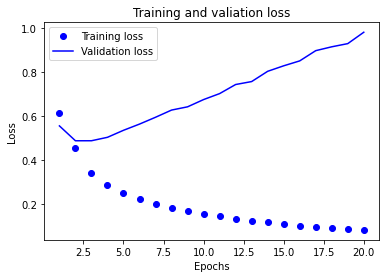

In [15]:
# plot the training and validation loss
import matplotlib.pyplot as plt

f1_score = history_dict['f1_score']
val_f1_score = history_dict['val_f1_score']

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(f1_score) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and valiation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

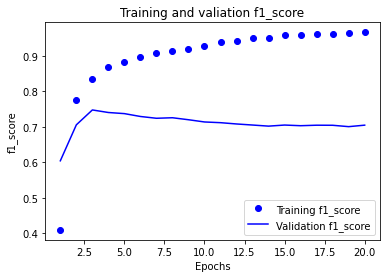

In [16]:
# plot the training and validation precision
plt.plot(epochs, f1_score, 'bo', label = 'Training f1_score')
plt.plot(epochs, val_f1_score, 'b', label = 'Validation f1_score')
plt.title('Training and valiation f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()

plt.show()

In [17]:
y_pred = model.predict(x_test)

y_pred = (y_pred > 0.5)

#  create a summary matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report, f1_score

target_names = ['Real Disaster', 'Fake Disaster']
print(classification_report(y_test, y_pred, target_names = target_names))

print("F1_score: ", f1_score(y_test, y_pred))

               precision    recall  f1-score   support

Real Disaster       0.79      0.76      0.78       870
Fake Disaster       0.70      0.74      0.71       653

     accuracy                           0.75      1523
    macro avg       0.74      0.75      0.74      1523
 weighted avg       0.75      0.75      0.75      1523

F1_score:  0.7148175725986596


## Model 2 - LSTM

In [27]:
lstm_out = 64

model2 = Sequential()
model2.add(Embedding(max_words, batch_size, input_length = max_len))
model2.add(LSTM(lstm_out))
model2.add(Dense(256, activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
model2.add(Dropout(0.5))
model2.add(Dense(1))
model2.add(Activation('sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = [f1_score])

In [28]:
# fit the model to the padded sequenced datasets
history = model2.fit(train_sequences_padded, y_train, callbacks=stop_early,
                     batch_size = batch_size, epochs = 100, validation_split=0.2)

Epoch 1/100
153/153 [==============================] - 2s 8ms/step - loss: 1.0111 - f1_score: 0.3329 - val_loss: 0.5608 - val_f1_score: 0.6538
Epoch 2/100
153/153 [==============================] - 1s 7ms/step - loss: 0.4269 - f1_score: 0.8137 - val_loss: 0.5162 - val_f1_score: 0.6999
Epoch 3/100
153/153 [==============================] - 1s 7ms/step - loss: 0.2998 - f1_score: 0.8851 - val_loss: 0.5705 - val_f1_score: 0.7040
Epoch 4/100
153/153 [==============================] - 1s 7ms/step - loss: 0.2256 - f1_score: 0.9264 - val_loss: 0.6383 - val_f1_score: 0.6833
Epoch 5/100
153/153 [==============================] - 1s 7ms/step - loss: 0.1870 - f1_score: 0.9430 - val_loss: 0.7228 - val_f1_score: 0.6906
Epoch 6/100
153/153 [==============================] - 1s 7ms/step - loss: 0.1471 - f1_score: 0.9559 - val_loss: 0.9198 - val_f1_score: 0.6663
Epoch 7/100
153/153 [==============================] - 1s 7ms/step - loss: 0.1225 - f1_score: 0.9642 - val_loss: 0.9767 - val_f1_score: 0.6701

In [29]:
# see the result of the model training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])

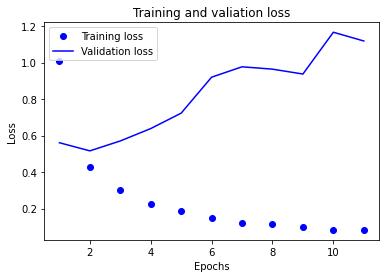

In [30]:
# plot the training and validation loss
import matplotlib.pyplot as plt

f1_score = history_dict['f1_score']
val_f1_score = history_dict['val_f1_score']

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(f1_score) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and valiation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

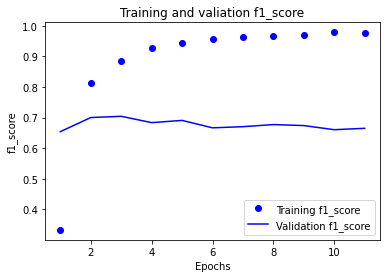

In [31]:
# plot the training and validation precision
plt.plot(epochs, f1_score, 'bo', label = 'Training f1_score')
plt.plot(epochs, val_f1_score, 'b', label = 'Validation f1_score')
plt.title('Training and valiation f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()

plt.show()

In [32]:
y_pred = model2.predict(test_sequences_padded)

y_pred = (y_pred>0.5)

#  create a summary matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report, f1_score

target_names = ['Real Disaster', 'Fake Disaster']
print(classification_report(y_test, y_pred, target_names = target_names))

print("F1_score: ", f1_score(y_test, y_pred))

               precision    recall  f1-score   support

Real Disaster       0.76      0.75      0.75       870
Fake Disaster       0.67      0.68      0.67       653

     accuracy                           0.72      1523
    macro avg       0.71      0.71      0.71      1523
 weighted avg       0.72      0.72      0.72      1523

F1_score:  0.6737967914438503


## Model 3 - Bidirectional LSTM

In [46]:
model3 = Sequential()
model3.add(Embedding(max_words, batch_size, input_length = max_len))
model3.add(Dropout(0.5))
model3.add(Bidirectional(LSTM(batch_size), merge_mode = 'sum'))
model3.add(Dense(256, activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation = 'sigmoid'))
model3.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = [f1_score])
print(model3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 15, 32)            320000    
                                                                 
 dropout_4 (Dropout)         (None, 15, 32)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               16640     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 256)               8448      
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                      

In [47]:
# fit the model to the padded sequenced datasets
history = model3.fit(train_sequences_padded, y_train, callbacks=stop_early,
                     batch_size = batch_size, verbose = 1, epochs = 100, validation_split=0.2)

Epoch 1/100
153/153 [==============================] - 3s 10ms/step - loss: 0.8587 - f1_score: 0.2582 - val_loss: 0.5365 - val_f1_score: 0.6869
Epoch 2/100
153/153 [==============================] - 1s 7ms/step - loss: 0.4316 - f1_score: 0.7906 - val_loss: 0.5063 - val_f1_score: 0.7159
Epoch 3/100
153/153 [==============================] - 1s 7ms/step - loss: 0.3218 - f1_score: 0.8708 - val_loss: 0.5333 - val_f1_score: 0.7158
Epoch 4/100
153/153 [==============================] - 1s 8ms/step - loss: 0.2524 - f1_score: 0.9035 - val_loss: 0.5727 - val_f1_score: 0.7003
Epoch 5/100
153/153 [==============================] - 1s 7ms/step - loss: 0.2006 - f1_score: 0.9268 - val_loss: 0.6440 - val_f1_score: 0.6874
Epoch 6/100
153/153 [==============================] - 1s 7ms/step - loss: 0.1742 - f1_score: 0.9392 - val_loss: 0.6535 - val_f1_score: 0.6753
Epoch 7/100
153/153 [==============================] - 1s 7ms/step - loss: 0.1536 - f1_score: 0.9480 - val_loss: 0.8130 - val_f1_score: 0.683

In [48]:
# see the result of the model training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])

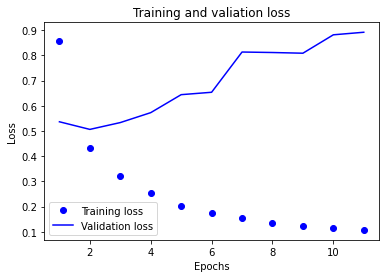

In [56]:
# plot the training and validation loss
import matplotlib.pyplot as plt

f1_score = history_dict['f1_score']
val_f1_score = history_dict['val_f1_score']

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(f1_score) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and valiation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

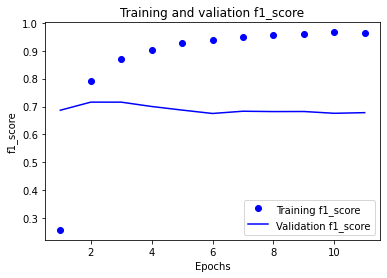

In [57]:
# plot the training and validation precision
plt.plot(epochs, f1_score, 'bo', label = 'Training f1_score')
plt.plot(epochs, val_f1_score, 'b', label = 'Validation f1_score')
plt.title('Training and valiation f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()

plt.show()

In [58]:
y_pred = model3.predict(test_sequences_padded)

y_pred = (y_pred>0.5)

#  create a summary matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report, f1_score

target_names = ['Real Disaster', 'Fake Disaster']
print(classification_report(y_test, y_pred, target_names = target_names))

print("F1_score: ", f1_score(y_test, y_pred))

               precision    recall  f1-score   support

Real Disaster       0.76      0.82      0.79       870
Fake Disaster       0.73      0.65      0.69       653

     accuracy                           0.74      1523
    macro avg       0.74      0.73      0.74      1523
 weighted avg       0.74      0.74      0.74      1523

F1_score:  0.6850202429149798


## Model 4 - Two Stacked Bidirectional LSTM

In [68]:
model4 = Sequential()
model4.add(Embedding(max_words, batch_size, input_length = max_len))
model4.add(Dropout(0.5))
model4.add(Bidirectional(LSTM(batch_size,  return_sequences=True), merge_mode = 'sum'))
model4.add(Bidirectional(LSTM(batch_size // 2), merge_mode = 'sum'))
model4.add(Dense(64, activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation = 'sigmoid'))
model4.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = [f1_score])
print(model4.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 15, 32)            320000    
                                                                 
 dropout_8 (Dropout)         (None, 15, 32)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 15, 32)           16640     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 16)               6272      
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 64)                1088      
                                                                 
 dropout_9 (Dropout)         (None, 64)               

In [69]:
# fit the model to the padded sequenced datasets
history = model4.fit(train_sequences_padded, y_train, callbacks=stop_early,
                     batch_size = batch_size, verbose = 1, epochs = 100, validation_split=0.2)

Epoch 1/100
153/153 [==============================] - 6s 16ms/step - loss: 0.7006 - f1_score: 0.4220 - val_loss: 0.5287 - val_f1_score: 0.7029
Epoch 2/100
153/153 [==============================] - 2s 10ms/step - loss: 0.4418 - f1_score: 0.7869 - val_loss: 0.4798 - val_f1_score: 0.7240
Epoch 3/100
153/153 [==============================] - 2s 10ms/step - loss: 0.3093 - f1_score: 0.8704 - val_loss: 0.5500 - val_f1_score: 0.7162
Epoch 4/100
153/153 [==============================] - 2s 10ms/step - loss: 0.2437 - f1_score: 0.9102 - val_loss: 0.5847 - val_f1_score: 0.7007
Epoch 5/100
153/153 [==============================] - 2s 10ms/step - loss: 0.1977 - f1_score: 0.9295 - val_loss: 0.6594 - val_f1_score: 0.6870
Epoch 6/100
153/153 [==============================] - 2s 10ms/step - loss: 0.1666 - f1_score: 0.9401 - val_loss: 0.7138 - val_f1_score: 0.6794
Epoch 7/100
153/153 [==============================] - 2s 11ms/step - loss: 0.1496 - f1_score: 0.9468 - val_loss: 0.7294 - val_f1_score:

In [70]:
# see the result of the model training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])

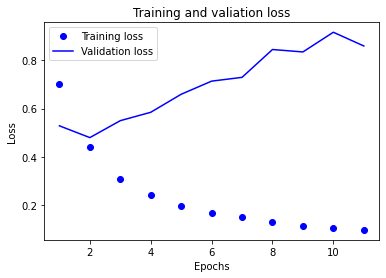

In [72]:
# plot the training and validation loss
import matplotlib.pyplot as plt

f1_score = history_dict['f1_score']
val_f1_score = history_dict['val_f1_score']

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(f1_score) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and valiation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

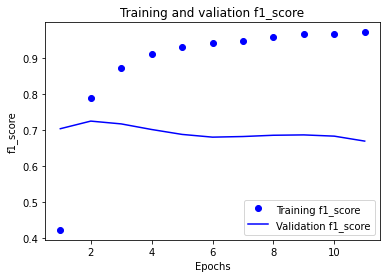

In [73]:
# plot the training and validation f1_score
plt.plot(epochs, f1_score, 'bo', label = 'Training f1_score')
plt.plot(epochs, val_f1_score, 'b', label = 'Validation f1_score')
plt.title('Training and valiation f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()

plt.show()

In [74]:
y_pred = model4.predict(test_sequences_padded)

y_pred = (y_pred > 0.5)

#  create a summary matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report, f1_score

target_names = ['Real Disaster', 'Fake Disaster']
print(classification_report(y_test, y_pred, target_names = target_names))

print("F1_score: ", f1_score(y_test, y_pred))

               precision    recall  f1-score   support

Real Disaster       0.75      0.84      0.79       870
Fake Disaster       0.74      0.62      0.68       653

     accuracy                           0.75      1523
    macro avg       0.74      0.73      0.73      1523
 weighted avg       0.74      0.75      0.74      1523

F1_score:  0.6777408637873754


## Model 5 - GloVe

In [82]:
vocab_size_glove=len(word_index)

embeddings_index = {};
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size_glove+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

model5=Sequential()
model5.add(Embedding(vocab_size_glove+1,100,weights=[embeddings_matrix],input_length=max_len,trainable=False))
model5.add(SpatialDropout1D(0.2))
model5.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer='adam',metrics=[f1_score])
model5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 15, 100)           1485600   
                                                                 
 spatial_dropout1d (SpatialD  (None, 15, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 1,566,101
Trainable params: 80,501
Non-trainable params: 1,485,600
_________________________________________________________________


In [83]:
# fit the model to the padded sequenced datasets
history = model5.fit(train_sequences_padded, y_train, callbacks=stop_early,
                     batch_size = batch_size, verbose = 1, epochs = 100, validation_split=0.2)

Epoch 1/100
153/153 [==============================] - 3s 11ms/step - loss: 0.5293 - f1_score: 0.6644 - val_loss: 0.4713 - val_f1_score: 0.6827
Epoch 2/100
153/153 [==============================] - 1s 9ms/step - loss: 0.4737 - f1_score: 0.7057 - val_loss: 0.4506 - val_f1_score: 0.7180
Epoch 3/100
153/153 [==============================] - 1s 10ms/step - loss: 0.4501 - f1_score: 0.7368 - val_loss: 0.4521 - val_f1_score: 0.6900
Epoch 4/100
153/153 [==============================] - 1s 10ms/step - loss: 0.4474 - f1_score: 0.7269 - val_loss: 0.4440 - val_f1_score: 0.7257
Epoch 5/100
153/153 [==============================] - 1s 9ms/step - loss: 0.4273 - f1_score: 0.7440 - val_loss: 0.4500 - val_f1_score: 0.7223
Epoch 6/100
153/153 [==============================] - 1s 9ms/step - loss: 0.4260 - f1_score: 0.7484 - val_loss: 0.4438 - val_f1_score: 0.7296
Epoch 7/100
153/153 [==============================] - 1s 10ms/step - loss: 0.4208 - f1_score: 0.7435 - val_loss: 0.4523 - val_f1_score: 0.

In [84]:
# see the result of the model training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])

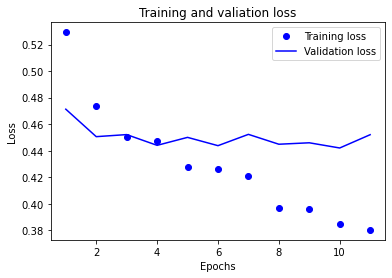

In [86]:
# plot the training and validation loss
import matplotlib.pyplot as plt

f1_score = history_dict['f1_score']
val_f1_score = history_dict['val_f1_score']

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(f1_score) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and valiation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

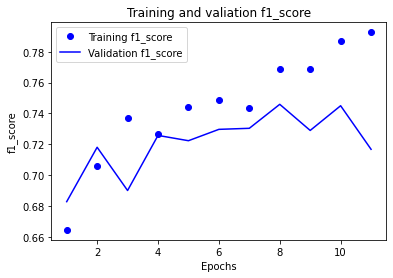

In [87]:
# plot the training and validation f1_score
plt.plot(epochs, f1_score, 'bo', label = 'Training f1_score')
plt.plot(epochs, val_f1_score, 'b', label = 'Validation f1_score')
plt.title('Training and valiation f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()

plt.show()

In [88]:
y_pred = model5.predict(test_sequences_padded)

y_pred = (y_pred > 0.5)

#  create a summary matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report, f1_score

target_names = ['Real Disaster', 'Fake Disaster']
print(classification_report(y_test, y_pred, target_names = target_names))

print("F1_score: ", f1_score(y_test, y_pred))

               precision    recall  f1-score   support

Real Disaster       0.76      0.93      0.84       870
Fake Disaster       0.87      0.62      0.72       653

     accuracy                           0.80      1523
    macro avg       0.82      0.77      0.78      1523
 weighted avg       0.81      0.80      0.79      1523

F1_score:  0.7228699551569506


## Model 6 - Convolutional NN

In [102]:
model6=Sequential()
model6.add(Embedding(max_words, batch_size, input_length = max_len))
model6.add(Dropout(0.5))
model6.add(keras.layers.Conv1D(128, 3, activation='relu'))
model6.add(keras.layers.MaxPooling1D(3))
model6.add(keras.layers.Conv1D(64, 2, activation='relu'))
model6.add(keras.layers.MaxPooling1D(2))
model6.add(keras.layers.Flatten())
model6.add(keras.layers.Dense(64, activation='relu'))
model6.add(keras.layers.Dense(1, activation = 'sigmoid'))
model6.compile(loss='binary_crossentropy', optimizer='adam',metrics=[f1_score])
model6.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 15, 32)            320000    
                                                                 
 dropout_15 (Dropout)        (None, 15, 32)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 13, 128)           12416     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 4, 128)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 3, 64)             16448     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                

In [103]:
# fit the model to the padded sequenced datasets
history = model6.fit(train_sequences_padded, y_train, callbacks=stop_early,
                     batch_size = batch_size, verbose = 1, epochs = 100, validation_split=0.2)

Epoch 1/100
153/153 [==============================] - 1s 5ms/step - loss: 0.6671 - f1_score: 0.1490 - val_loss: 0.5738 - val_f1_score: 0.6066
Epoch 2/100
153/153 [==============================] - 1s 5ms/step - loss: 0.4796 - f1_score: 0.7107 - val_loss: 0.5130 - val_f1_score: 0.6681
Epoch 3/100
153/153 [==============================] - 1s 4ms/step - loss: 0.3490 - f1_score: 0.8124 - val_loss: 0.5367 - val_f1_score: 0.6844
Epoch 4/100
153/153 [==============================] - 1s 4ms/step - loss: 0.2639 - f1_score: 0.8686 - val_loss: 0.5965 - val_f1_score: 0.6518
Epoch 5/100
153/153 [==============================] - 1s 5ms/step - loss: 0.2167 - f1_score: 0.8987 - val_loss: 0.6621 - val_f1_score: 0.6802
Epoch 6/100
153/153 [==============================] - 1s 4ms/step - loss: 0.1822 - f1_score: 0.9163 - val_loss: 0.6529 - val_f1_score: 0.6645
Epoch 7/100
153/153 [==============================] - 1s 5ms/step - loss: 0.1470 - f1_score: 0.9346 - val_loss: 0.7842 - val_f1_score: 0.6544

In [104]:
# see the result of the model training
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])

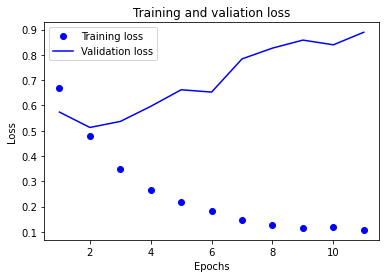

In [109]:
# plot the training and validation loss
import matplotlib.pyplot as plt

f1_score = history_dict['f1_score']
val_f1_score = history_dict['val_f1_score']

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(f1_score) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and valiation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

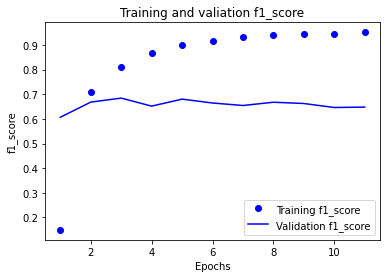

In [110]:
# plot the training and validation f1_score
plt.plot(epochs, f1_score, 'bo', label = 'Training f1_score')
plt.plot(epochs, val_f1_score, 'b', label = 'Validation f1_score')
plt.title('Training and valiation f1_score')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()

plt.show()

In [111]:
y_pred = model6.predict(test_sequences_padded)

y_pred = (y_pred > 0.5)

#  create a summary matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

from sklearn.metrics import classification_report, f1_score

target_names = ['Real Disaster', 'Fake Disaster']
print(classification_report(y_test, y_pred, target_names = target_names))

print("F1_score: ", f1_score(y_test, y_pred))

               precision    recall  f1-score   support

Real Disaster       0.73      0.80      0.76       870
Fake Disaster       0.70      0.61      0.65       653

     accuracy                           0.72      1523
    macro avg       0.71      0.70      0.71      1523
 weighted avg       0.72      0.72      0.72      1523

F1_score:  0.6503667481662592


## Model Hyperparameter Tuning

In [142]:
vocab_size_glove=len(word_index)

embeddings_index = {};
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size_glove+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

# define the function that defined the search space of the tuner
def model_builder(hp):
    tuned_model = keras.Sequential()
    tuned_model.add(Embedding(vocab_size_glove+1,100,weights=[embeddings_matrix],input_length=max_len,trainable=False))
    tuned_model.add(SpatialDropout1D(hp.Float('dropout_rate', 0, 0.5, step=0.1, default=0.5)))
    tuned_model.add(LSTM(units=hp.Int('LSTM_units', 25, 200, step=25),
                                    dropout = hp.Float('LSTM_dropout_rate', 0, 0.5, step=0.1, default=0.5),
                                    recurrent_dropout = hp.Float('LSTM_recurrent_dropout_rate', 0, 0.5, step=0.1, default=0.5)))
    for i in range(hp.Int('layers', 1, 3)):
        tuned_model.add(tf.keras.layers.Dense(units=hp.Int('Dense_units_' + str(i), 1, 26, step=2),
                                        activation=hp.Choice('Dense_act_' + str(i), ['relu', 'elu']),
                                        kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
        if hp.Boolean("dropout_" + str(i)):
            tuned_model.add(Dropout(hp.Float('dropout_rate_'+ str(i), 0, 0.5, step=0.1, default=0.5)))
    tuned_model.add(Dense(1, activation = 'sigmoid'))
    optimizer = hp.Choice("optimizer", ["adam", "sgd", "rmsprop"])
    tuned_model.compile(optimizer, loss = 'binary_crossentropy', metrics = [f1_score])

    return tuned_model

In [143]:
# compile the tuner with the Hyperband method and the objective function to be achieved
tuner = kt.Hyperband(
    model_builder,
    factor=3,
    objective = kt.Objective("val_f1_score", direction="max"),
    project_name="Disaster",
    overwrite=True,
    hyperband_iterations=2)

In [144]:
# run the tuner over the padded seqenced datasets
tuner.search(train_sequences_padded, y_train, validation_split = 0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

print(best_hps.values)

best_model = tuner.get_best_models()[0]

Trial 508 Complete [00h 01m 49s]
val_f1_score: 0.754648745059967

Best val_f1_score So Far: 0.7753095626831055
Total elapsed time: 04h 17m 26s
INFO:tensorflow:Oracle triggered exit
{'dropout_rate': 0.2, 'LSTM_units': 75, 'LSTM_dropout_rate': 0.30000000000000004, 'LSTM_recurrent_dropout_rate': 0.1, 'layers': 2, 'Dense_units_0': 7, 'Dense_act_0': 'elu', 'dropout_0': False, 'optimizer': 'rmsprop', 'Dense_units_1': 11, 'Dense_act_1': 'elu', 'dropout_1': True, 'dropout_rate_1': 0.1, 'dropout_rate_0': 0.2, 'Dense_units_2': 13, 'Dense_act_2': 'elu', 'dropout_2': False, 'dropout_rate_2': 0.30000000000000004, 'tuner/epochs': 34, 'tuner/initial_epoch': 12, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': 'd47842a655a89899bdca4dc6f3a19da1'}


## Final Model

In [230]:
vocab_size_glove=len(word_index)

embeddings_index = {};
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size_glove+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

final_model=Sequential()
final_model.add(Embedding(vocab_size_glove+1,100,weights=[embeddings_matrix],input_length=max_len,trainable=False))
final_model.add(SpatialDropout1D(0.2))
final_model.add(LSTM(75, dropout=0.3, recurrent_dropout=0.1))
final_model.add(Dense(7, activation = 'elu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
final_model.add(Dense(11, activation = 'elu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
final_model.add(Dropout(0.1))
final_model.add(Dense(1, activation='sigmoid'))
final_model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=[f1_score])
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 15, 100)           1485600   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 15, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 75)                52800     
                                                                 
 dense_9 (Dense)             (None, 7)                 532       
                                                                 
 dense_10 (Dense)            (None, 11)                88        
                                                                 
 dropout_3 (Dropout)         (None, 11)                0         
                                                      

In [231]:
# join the train and test datasets to be fed to the final model
features_sequences_padded = np.concatenate((train_sequences_padded, test_sequences_padded))

# join the labels
labels = np.append(y_train,y_test)

In [233]:
# fit the model to the final joined padded sequenced dataset
history = final_model.fit(features_sequences_padded, labels, epochs = 34, initial_epoch = 12,
                          batch_size = batch_size, callbacks=[stop_early])

# see the result of the model training
history_dict = history.history
history_dict.keys()

Epoch 13/34
238/238 [==============================] - 5s 20ms/step - loss: 0.4506 - f1_score: 0.7520
Epoch 14/34
238/238 [==============================] - 5s 20ms/step - loss: 0.4412 - f1_score: 0.7570
Epoch 15/34
238/238 [==============================] - 5s 20ms/step - loss: 0.4302 - f1_score: 0.7586
Epoch 16/34
238/238 [==============================] - 5s 20ms/step - loss: 0.4277 - f1_score: 0.7606
Epoch 17/34
238/238 [==============================] - 5s 19ms/step - loss: 0.4198 - f1_score: 0.7752
Epoch 18/34
238/238 [==============================] - 5s 19ms/step - loss: 0.4143 - f1_score: 0.7720
Epoch 19/34
238/238 [==============================] - 5s 20ms/step - loss: 0.4074 - f1_score: 0.7820
Epoch 20/34
238/238 [==============================] - 5s 20ms/step - loss: 0.4069 - f1_score: 0.7792
Epoch 21/34
238/238 [==============================] - 5s 20ms/step - loss: 0.3981 - f1_score: 0.7844
Epoch 22/34
238/238 [==============================] - 5s 20ms/step - loss: 0.3973

dict_keys(['loss', 'f1_score'])

In [234]:
# load the datsets
test = pd.read_csv('test.csv')['text']

#apply the same preprocessing procedure as used in the training dataset
test = normalize(test)

test_sequences = token.texts_to_sequences(test)

test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)

test = vectorize_sequences(test_sequences_padded)

In [235]:
# make the final prediction for the test dataset 
y_pre=final_model.predict(test_sequences_padded)
y_pre=np.round(y_pre).astype(int).reshape(3263)

# generate a csv file to submit into Kaggle competition
sub=pd.DataFrame({'id':pd.read_csv('test.csv')['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)